In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt #  plotting and data visualization
import seaborn as sns # improve visuals
sns.set() # Set as default style

import string # python library
import re # regex library

from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric, remove_stopwords, strip_short # Preprocesssing
from gensim.models import Word2Vec # Word2vec

from sklearn import cluster # Kmeans clustering
from sklearn import metrics # Metrics for evaluation
from sklearn.decomposition import PCA #PCA
from sklearn.manifold import TSNE #TSNE

In [4]:
from wordcloud import WordCloud, STOPWORDS

In [8]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
# from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize

In [5]:
fake = pd.read_csv('Fake.csv')
true = pd.read_csv('True.csv')

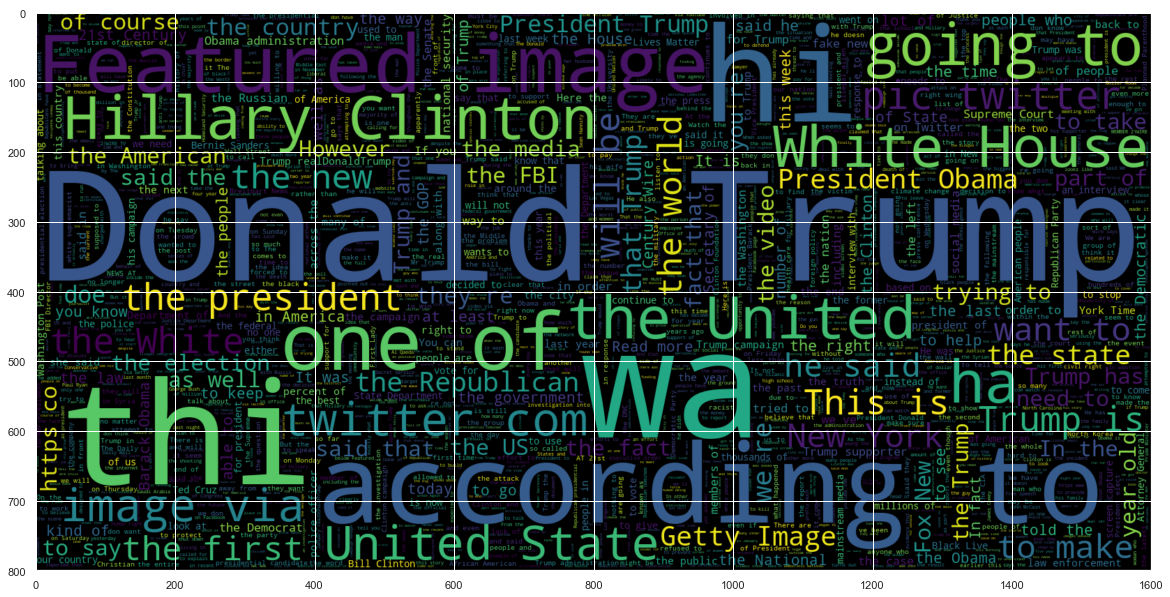

In [10]:
plt.figure(figsize = (20,20)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(fake.text))
plt.imshow(wc , interpolation = 'bilinear')

In [11]:
true.head(10)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
5,"White House, Congress prepare for talks on spe...","WEST PALM BEACH, Fla./WASHINGTON (Reuters) - T...",politicsNews,"December 29, 2017"
6,"Trump says Russia probe will be fair, but time...","WEST PALM BEACH, Fla (Reuters) - President Don...",politicsNews,"December 29, 2017"
7,Factbox: Trump on Twitter (Dec 29) - Approval ...,The following statements were posted to the ve...,politicsNews,"December 29, 2017"
8,Trump on Twitter (Dec 28) - Global Warming,The following statements were posted to the ve...,politicsNews,"December 29, 2017"
9,Alabama official to certify Senator-elect Jone...,WASHINGTON (Reuters) - Alabama Secretary of St...,politicsNews,"December 28, 2017"


In [12]:
# The following is a crude way to remove the @realDonaldTrump tweet disclaimer and State/Publisher at start of text

cleansed_data = []
for data in true.text:
    if "@realDonaldTrump : - " in data:
        cleansed_data.append(data.split("@realDonaldTrump : - ")[1])
    elif "(Reuters) -" in data:
        cleansed_data.append(data.split("(Reuters) - ")[1])
    else:
        cleansed_data.append(data)

true["text"] = cleansed_data
true.head(10)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017"
5,"White House, Congress prepare for talks on spe...",The White House said on Friday it was set to k...,politicsNews,"December 29, 2017"
6,"Trump says Russia probe will be fair, but time...",President Donald Trump said on Thursday he bel...,politicsNews,"December 29, 2017"
7,Factbox: Trump on Twitter (Dec 29) - Approval ...,While the Fake News loves to talk about my so-...,politicsNews,"December 29, 2017"
8,Trump on Twitter (Dec 28) - Global Warming,"Together, we are MAKING AMERICA GREAT AGAIN! b...",politicsNews,"December 29, 2017"
9,Alabama official to certify Senator-elect Jone...,Alabama Secretary of State John Merrill said h...,politicsNews,"December 28, 2017"


In [13]:
fake['Sentences'] = fake['title'] + ' ' + fake['text']
true['Sentences'] = true['title'] + ' ' + true['text']

# Adding fake and true label
fake['Label'] = 0
true['Label'] = 1

# We can merge both together since we now have labels
final_data = pd.concat([fake, true])

# Randomize the rows so its all mixed up
final_data = final_data.sample(frac=1).reset_index(drop=True)

# Drop columns not needed
final_data = final_data.drop(['title', 'text', 'subject', 'date'], axis = 1)

final_data.head(10)

,Sentences,Label
0,HILLARY SUPPORTER BRAGS About Looting “White B...,0
1,Trump's FBI comments to Russians were aimed at...,1
2,"Trump praises 'productive' China talks, but to...",1
3,McMaster says 'of course' Trump supports NATO ...,1
4,U.S. committed to bringing American hostages h...,1
5,Episode #153 – SUNDAY WIRE: ‘The Nuremberg Syn...,0
6,"Trapped by landmines and a creek, Rohingya lan...",1
7,Wilbur Ross seen as Trump pick for Commerce De...,1
8,RICK SANTORUM INFURIATES LIBERALS After He Tel...,0
9,EU Parliament names press room after murdered ...,1


In [14]:
def remove_URL(s):
    regex = re.compile(r'https?://\S+|www\.\S+|bit\.ly\S+')
    return regex.sub(r'',s)

# Preprocessing functions to remove lowercase, links, whitespace, tags, numbers, punctuation, strip words
CUSTOM_FILTERS = [lambda x: x.lower(), strip_tags, remove_URL, strip_punctuation, strip_multiple_whitespaces, strip_numeric, remove_stopwords, strip_short]

# Here we store the processed sentences and their label
processed_data = []
processed_labels = []

for index, row in final_data.iterrows():
    words_broken_up = preprocess_string(row['Sentences'], CUSTOM_FILTERS)
    # This eliminates any fields that may be blank after preprocessing
    if len(words_broken_up) > 0:
        processed_data.append(words_broken_up)
        processed_labels.append(row['Label'])

In [67]:
# Word2Vec model trained on processed data
model = Word2Vec(processed_data,size=20, min_count=1)

In [68]:
model.wv.most_similar("sunny")

[('imus', 0.9147040247917175),
 ('burnett', 0.8983653783798218),
 ('geraldo', 0.8949955701828003),
 ('eastwood', 0.8932493925094604),
 ('rutler', 0.881877064704895),
 ('pitt', 0.8805171847343445),
 ('nicholle', 0.8798024654388428),
 ('les', 0.878131091594696),
 ('wilmore', 0.8770841956138611),
 ('fey', 0.8762925863265991)]

In [69]:
# Getting the vector of a sentence based on average of all the word vectors in the sentence
# We get the average as this accounts for different sentence lengths

def ReturnVector(x):
    try:
        return model[x]
    except:
        return np.zeros(20)
    
def Sentence_Vector(sentence):
    word_vectors = list(map(lambda x: ReturnVector(x), sentence))
    return np.average(word_vectors, axis=0).tolist()

X = []
for data_x in processed_data:
    X.append(Sentence_Vector(data_x))

C:\Users\MAHSA\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [70]:
X_np = np.array(X)
X_np.shape

(44889, 20)

In [71]:
X_np[0:10]

array([[-3.04207265e-01,  9.82500851e-01, -1.16052032e+00,
        -5.94026387e-01, -1.70456243e+00,  1.24218933e-01,
         8.17383826e-01, -2.54015386e-01,  5.17222956e-02,
         1.63043380e-01, -5.89063823e-01, -1.15277755e+00,
        -1.45851207e+00,  7.24176317e-02, -1.83457240e-01,
         1.69250682e-01,  3.46627444e-01,  3.75483632e-01,
         8.45672250e-01,  1.95038366e+00],
       [ 1.00193667e+00,  1.10644352e+00, -1.65811498e-02,
        -2.21424460e+00,  8.20958987e-02, -1.17898178e+00,
         1.03236818e+00, -3.15203476e+00,  6.47965610e-01,
        -1.33630157e-01, -6.87363327e-01, -6.31833732e-01,
         2.93404341e-01, -2.90051132e-01,  6.54917300e-01,
         9.43892121e-01,  1.04554987e+00,  1.15168238e+00,
         6.37708068e-01, -2.13273019e-01],
       [ 9.21334684e-01,  1.59536922e+00,  5.98143339e-01,
        -7.55561709e-01,  3.77778053e-01,  5.49329147e-02,
         3.55110377e-01, -2.13206577e+00,  6.43082380e-01,
        -8.49792123e-01, -1.9

In [72]:
from sklearn import preprocessing

In [73]:
min_max_scaler = preprocessing.MinMaxScaler()
data_normalize = min_max_scaler.fit_transform(X_np)

In [74]:
data_normalize[0:10]

array([[0.29050627, 0.64152588, 0.39647449, 0.49291026, 0.40629922,
        0.69930292, 0.43475038, 0.64649043, 0.3443535 , 0.67327557,
        0.56238217, 0.45139835, 0.41236614, 0.50645902, 0.50736356,
        0.50568475, 0.49749492, 0.40558959, 0.64071298, 0.60164763],
       [0.53609349, 0.65795167, 0.58618945, 0.3031725 , 0.61856272,
        0.49269465, 0.47892889, 0.22991916, 0.46634814, 0.63283427,
        0.54514249, 0.51989521, 0.71578748, 0.44666974, 0.64335261,
        0.62733228, 0.62506008, 0.56058141, 0.61446462, 0.35506271],
       [0.52093833, 0.72274772, 0.68813756, 0.47399345, 0.65369117,
        0.68831837, 0.33975483, 0.37653301, 0.465349  , 0.53521005,
        0.31582148, 0.62078077, 0.57442128, 0.40157057, 0.36788851,
        0.61975867, 0.67423455, 0.52025999, 0.46763598, 0.40610241],
       [0.64573302, 0.67494929, 0.53142899, 0.46622352, 0.63854982,
        0.62612993, 0.42562685, 0.30451605, 0.40480009, 0.52308424,
        0.42939252, 0.53639847, 0.58045773, 0

In [84]:
# Training for 2 clusters (Fake and Real)
kmeans = cluster.KMeans(n_clusters=2, verbose=1)

# Fit predict will return labels
clustered = kmeans.fit_predict(data_normalize)

Initialization complete
Iteration 0, inertia 19016.406747144043
Iteration 1, inertia 9356.603982219154
Iteration 2, inertia 8989.498671333648
Iteration 3, inertia 8780.028491047926
Iteration 4, inertia 8709.210483586961
Iteration 5, inertia 8681.080432559009
Iteration 6, inertia 8669.406559435429
Iteration 7, inertia 8664.326028703383
Iteration 8, inertia 8662.260008283623
Iteration 9, inertia 8661.570348750969
Iteration 10, inertia 8661.38086760035
Iteration 11, inertia 8661.286544808927
Converged at iteration 11: center shift 1.0447166745695276e-06 within tolerance 1.1684857178583388e-06
Initialization complete
Iteration 0, inertia 19591.501710228786
Iteration 1, inertia 9855.79230662915
Iteration 2, inertia 9569.819920957336
Iteration 3, inertia 9192.652636451221
Iteration 4, inertia 8840.12042994464
Iteration 5, inertia 8701.985514171283
Iteration 6, inertia 8671.723365781669
Iteration 7, inertia 8664.348405092882
Iteration 8, inertia 8662.158017261314
Iteration 9, inertia 8661.536

In [85]:
testing_df = {'Sentence': processed_data, 'Labels': processed_labels, 'Prediction': clustered}
testing_df = pd.DataFrame(data=testing_df)

testing_df.head(10)

,Sentence,Labels,Prediction
0,"[hillary, supporter, brags, looting, “white, b...",0,1
1,"[trump, fbi, comments, russians, aimed, cooper...",1,0
2,"[trump, praises, productive, china, talks, tou...",1,0
3,"[mcmaster, says, course, trump, supports, nato...",1,0
4,"[committed, bringing, american, hostages, home...",1,0
5,"[episode, sunday, wire, ‘the, nuremberg, syndr...",0,0
6,"[trapped, landmines, creek, rohingya, languish...",1,0
7,"[wilbur, ross, seen, trump, pick, commerce, de...",1,0
8,"[rick, santorum, infuriates, liberals, tells, ...",0,1
9,"[parliament, names, press, room, murdered, mal...",1,0


In [86]:
correct = 0
incorrect = 0
for index, row in testing_df.iterrows():
    if row['Labels'] == row['Prediction']:
        correct += 1
    else:
        incorrect += 1
        
print("Correctly clustered news: " + str((correct*100)/(correct+incorrect)) + "%")

Correctly clustered news: 15.411347991712892%


In [87]:
labels = testing_df['Labels'].values
labels

array([0, 1, 1, ..., 0, 1, 0], dtype=int64)

In [88]:
prediction = testing_df['Prediction'].values
prediction

array([1, 0, 0, ..., 1, 1, 1])

In [89]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support

In [90]:
cm = confusion_matrix(labels,prediction)
cm

array([[ 3923, 19549],
       [18422,  2995]], dtype=int64)

In [91]:
cm = pd.DataFrame(cm , index = ['Fake','Original'] , columns = ['Fake','Original'])

Text(66.5, 0.5, 'Actual')

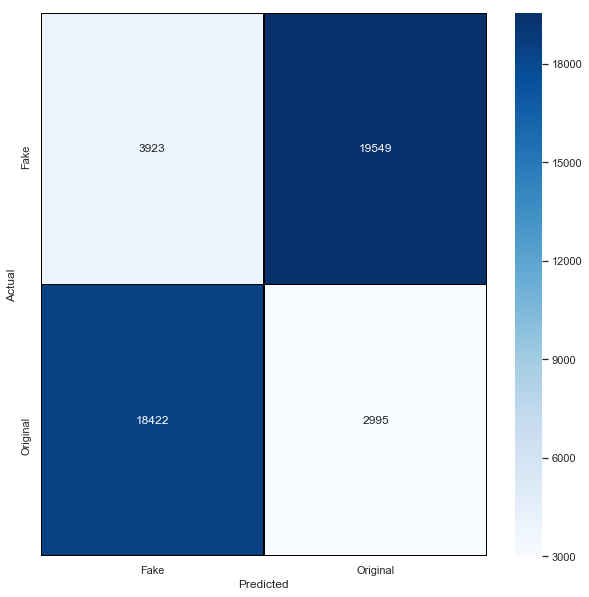

In [92]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Original'] , yticklabels = ['Fake','Original'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [99]:
data_normalize.shape

(44889, 20)

In [100]:
testing_df['Labels'].shape

(44889,)

In [102]:
data_normalize1 = np.append(data_normalize, asarray(testing_df['Labels']).reshape(44889,1) , axis=1)

In [105]:
data_normalize1[1]

array([0.53609349, 0.65795167, 0.58618945, 0.3031725 , 0.61856272,
       0.49269465, 0.47892889, 0.22991916, 0.46634814, 0.63283427,
       0.54514249, 0.51989521, 0.71578748, 0.44666974, 0.64335261,
       0.62733228, 0.62506008, 0.56058141, 0.61446462, 0.35506271,
       1.        ])

In [95]:
# save numpy array as csv file
from numpy import asarray
from numpy import savetxt


In [106]:
savetxt('data_news1.csv', data_normalize1, delimiter=',')